<IPython.core.display.Javascript object>


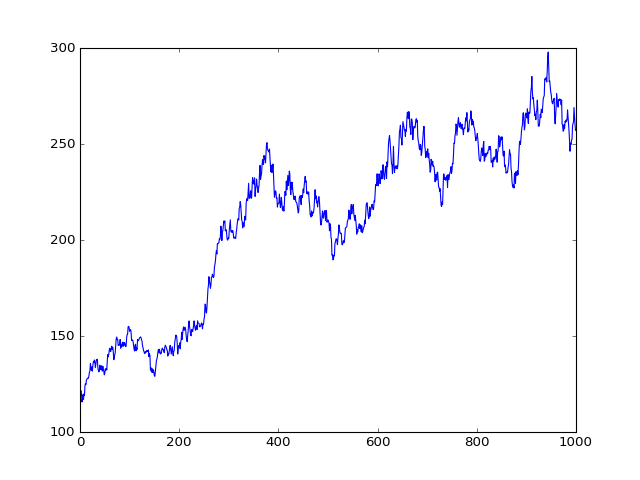

In [169]:
import pandas
import random
import numpy as np
from matplotlib import pyplot as plt

% matplotlib notebook

data = pandas.read_csv('WF.csv')

prices = []
for i in np.arange(len(data['price'])):
    prices.append(data['price'][i])

plt.figure('prices')
plt.plot(np.arange(len(prices)), prices)
plt.show()

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)

In [3]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(prices)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))



(670, 330)


/Users/dmitrynekhaev/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/dmitrynekhaev/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=0):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back+ look_forward])
    return np.array(dataX), np.array(dataY)

(569, 100, 1) (569,)
(229, 100, 1) (229,)


<IPython.core.display.Javascript object>


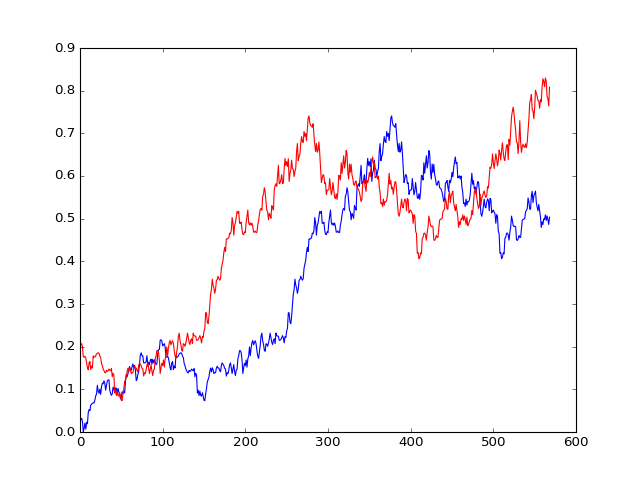

In [37]:
train_X, train_Y = create_dataset(train, look_back=100, look_forward=0)
test_X, test_Y = create_dataset(test, look_back=100, look_forward=0)

train_X = np.array(train_X)
train_Y = np.array(train_Y)
test_X = np.array(test_X)
test_Y = np.array(test_Y)

train_X = train_X.reshape(-1, 100, 1)
test_X = test_X.reshape(-1, 100, 1)

print train_X.shape, train_Y.shape
print test_X.shape, test_Y.shape

plt.figure('test')
plt.plot(np.arange(len(train_X)), train_X[:,0,:])
plt.plot(np.arange(len(train_Y)), train_Y, color='red')
plt.show()

In [38]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor3("X")
target_y = T.vector("target Y integer",dtype='float64')

In [50]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape=(None, 100, 1), input_var=input_X)

#полносвязный слой, который принимает на вход input layer и имеет 100 нейронов.
# нелинейная функция - сигмоида как в логистической регрессии
# слоям тоже можно давать имена, но это необязательно
#dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=20, nonlinearity=rectify, name="hidden_dense_layer")

dense_1 = lasagne.layers.LSTMLayer(
        input_layer, 50, grad_clipping=100,
        nonlinearity=lasagne.nonlinearities.tanh)

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 1, nonlinearity=rectify)

#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, cell_init, hid_init, W, b]


In [51]:
#функция ошибки

mse = ((y_predicted - target_y)**2).mean()
#loss = theano.function([y_predicted, target_y],[mse])

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adagrad(mse, all_weights,learning_rate=0.01)

In [52]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[mse,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

test_loss = theano.function([input_X, target_y], mse)

output_y = theano.function([input_X], y_predicted)

In [53]:
# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# inputs - тензор из картинок размером (много, 1, 28, 28), например - X_train
# targets - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
# batchsize - одно число - желаемый размер группы

#что нужно сделать
# 1) перемешать данные
# - важно перемешать targets и targets одним и тем же образом, чтобы сохранить соответствие картинки ответу на неё
# 3) побить данные на подгруппы так, чтобы в каждой подгруппе было batchsize картинок и ответов
# - если число картинок не делится на batchsize, одну подгруппу можно вернуть другого размера
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [54]:
import time

num_epochs = 200 #количество проходов по данным

batch_size = 10 #размер мини-батча

train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(train_X, train_Y,batch_size):
        inputs, targets = batch
        train_err_batch, s = train_fun(inputs, targets)
        train_err += train_err_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_batches = 0
    for batch in iterate_minibatches(test_X, test_Y, batch_size):
        inputs, targets = batch
        val_batches += 1
        val_err += test_loss(test_X, test_Y)

    if epoch % 10 == 0:
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss (in-iteration):\t\t{:.6f}".format(val_err / val_batches))
    
    train_losses.append(train_err / train_batches)
    test_losses.append(val_err / val_batches)

Epoch 1 of 200 took 5.971s
  training loss (in-iteration):		0.047764
  validation loss (in-iteration):		0.021587
Epoch 11 of 200 took 4.762s
  training loss (in-iteration):		0.002559
  validation loss (in-iteration):		0.027477
Epoch 21 of 200 took 5.770s
  training loss (in-iteration):		0.002219
  validation loss (in-iteration):		0.021225
Epoch 31 of 200 took 4.646s
  training loss (in-iteration):		0.001783
  validation loss (in-iteration):		0.016300
Epoch 41 of 200 took 4.851s
  training loss (in-iteration):		0.001517
  validation loss (in-iteration):		0.013521
Epoch 51 of 200 took 4.739s
  training loss (in-iteration):		0.001376
  validation loss (in-iteration):		0.012155
Epoch 61 of 200 took 4.969s
  training loss (in-iteration):		0.001288
  validation loss (in-iteration):		0.011451
Epoch 71 of 200 took 5.116s
  training loss (in-iteration):		0.001224
  validation loss (in-iteration):		0.011039
Epoch 81 of 200 took 4.498s
  training loss (in-iteration):		0.001175
  validation loss (

<IPython.core.display.Javascript object>


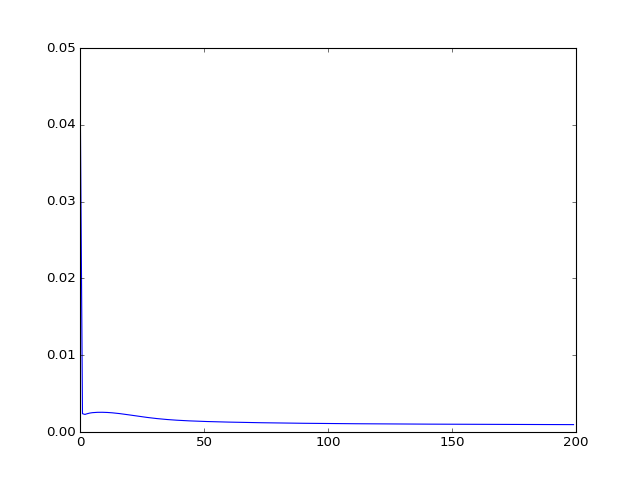

<IPython.core.display.Javascript object>


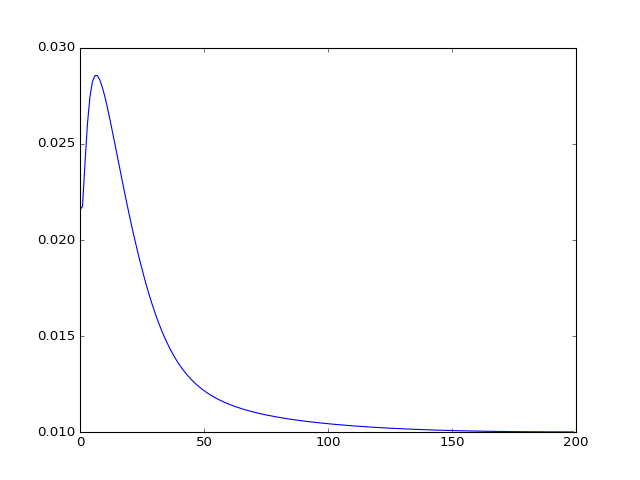

In [55]:
plt.figure('train_loss')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.show()

plt.figure('test_loss')
plt.plot(np.arange(len(test_losses)), test_losses)
plt.show()

In [56]:
train_answers = output_y(train_X)
test_answers = output_y(test_X)

<IPython.core.display.Javascript object>


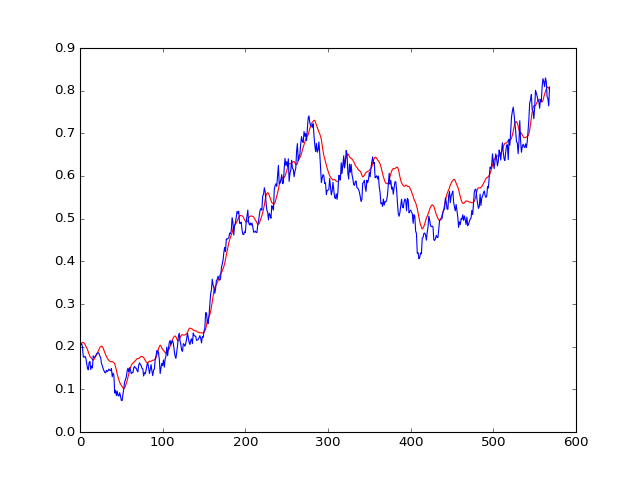

<IPython.core.display.Javascript object>


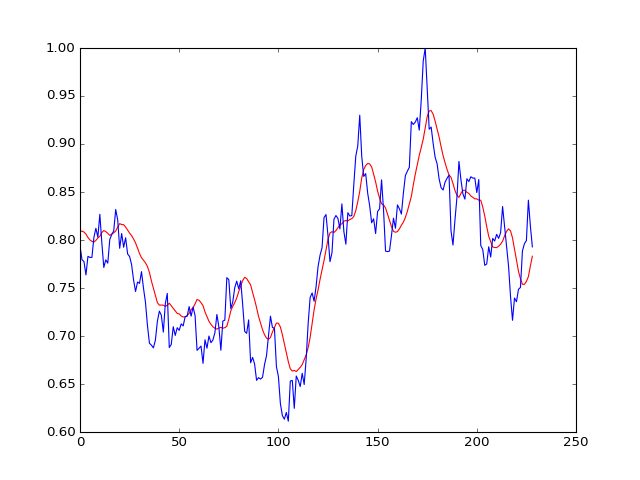

In [57]:
mistakes_train = [a - y for a,y in zip(train_answers, train_Y)]
#train_m = np.mean(mistakes_train)

mistakes_test = [a - y for a,y in zip(test_answers, test_Y)]
#test_m = np.mean(mistakes_test)

plt.figure('train2')
plt.plot(np.arange(len(train_answers)), train_answers, color='red')
plt.plot(np.arange(len(train_Y)), train_Y)
plt.show()

plt.figure('test2')
plt.plot(np.arange(len(test_answers)), test_answers, color='red')
plt.plot(np.arange(len(test_Y)), test_Y)
plt.show()

0.0180882688945
0.0297001982343
0.00965523476265
0.0345277218866


<IPython.core.display.Javascript object>


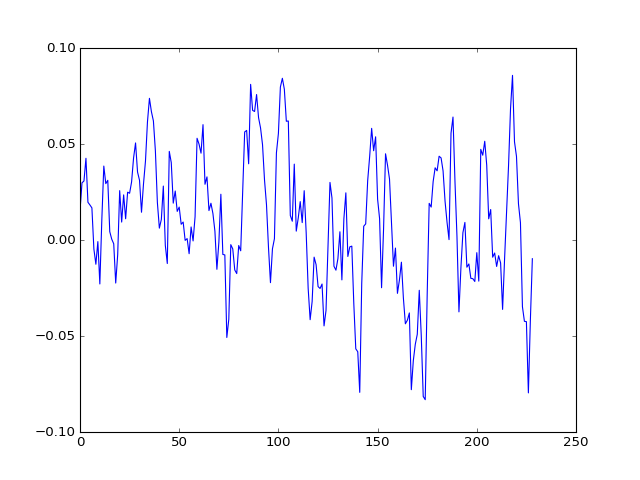

In [88]:
mistakes_train = [a - y for a,y in zip(train_answers, train_Y)]
print np.mean(mistakes_train)
print np.std(mistakes_train)

mistakes_test = [a - y for a,y in zip(test_answers, test_Y)]
print np.mean(mistakes_test)
print np.std(mistakes_test)

plt.figure('mistakes_test')
plt.plot(np.arange(len(mistakes_test)), mistakes_test)
plt.show()

In [125]:
from copy import deepcopy

prediction_list = []
# BOOOOOOOTSTRAAAAAAP NOOOOOW 0.0893
for m in np.arange(1000):
    if m % 50 ==0:
        print m
    simulation_set = deepcopy(test_X[-1].reshape(1, 100, 1))
    NN_preds = []
    for k in np.arange(0, 400):
        NN_pred = output_y(simulation_set)[0]
        
        simulation_set[:,:99,:] = simulation_set[:,1:,:]
        noise_i = np.random.randint(0,len(mistakes_train))
        pr = NN_pred + mistakes_train[noise_i]
        simulation_set[:,99,:] = pr
        
        NN_preds.append(pr)
    prediction_list.append(NN_preds)
    
#NN_preds = []
#for k in np.arange(400):
#    NN_pred = output_y(simulation_set)[0]
#    simulation_set[:,:99,:] = simulation_set[:,1:,:]
#    simulation_set[:,99,:] = NN_pred + 0.034*np.random.randn() + 0.01
#    NN_preds.append(NN_pred)
    
print len(prediction_list), len(prediction_list[0])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000 400


<IPython.core.display.Javascript object>


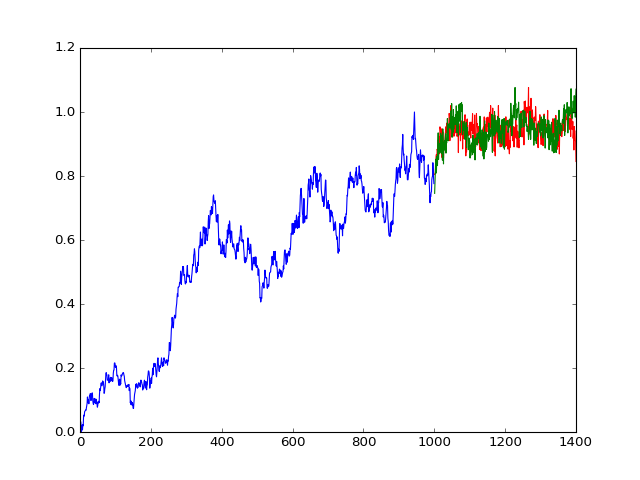

In [126]:
minimum = np.argmin(np.array(prediction_list)[:,-1])
maximum = np.argmax(np.array(prediction_list)[:,-1])


plt.figure('prs')
plt.plot(np.arange(1001, 1401), prediction_list[minimum], color='red')
plt.plot(np.arange(1001, 1401), prediction_list[maximum], color='green')
#plt.plot(np.arange(1001, 1401), predictions, color='yellow')
plt.plot(np.arange(len(dataset)), dataset)
plt.show()

<IPython.core.display.Javascript object>


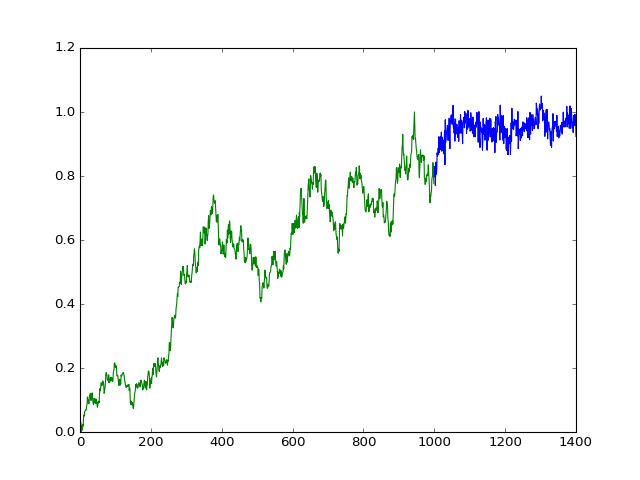

In [127]:
plt.figure('test3')
plt.plot(np.arange(1001,1401), NN_preds)
plt.plot(np.arange(1000), dataset)
plt.show()

In [128]:
recovered_prices = np.array(prediction_list)[:,-1] * (np.max(prices) - np.min(prices)) + np.min(prices)

290.158203214
6.71301863599


<IPython.core.display.Javascript object>


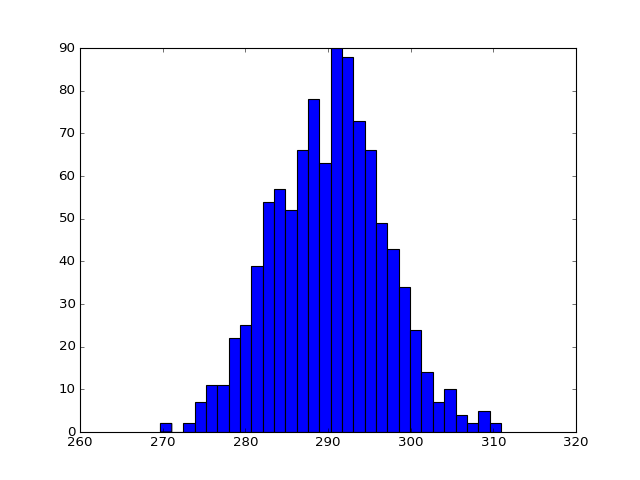

In [129]:
print np.mean(recovered_prices)
print np.std(recovered_prices)

plt.figure('hists400')
plt.hist(recovered_prices, bins=30)
plt.show()

In [196]:
bets = np.arange(0, 1, 0.01)
choose_bet = []
for k in np.arange(1000):
    moneys = []
    for bet in bets:
        money = 0
        for i in np.arange(100):
            money -= bet
            value = recovered_prices[np.random.randint(0, len(recovered_prices)-1)]
            if value > 300.:
                money += value - 300.
                #print 'BINGOO', value - 300.
            else:
                money += 0.
        moneys.append(money)       
    
    highest_bet = 0.
    for i in np.arange(len(moneys)):
        if moneys[i] > 0:
            highest_bet = bets[i]
        else: pass

    choose_bet.append(highest_bet)

0.37722
0.0836915264528
I can play this game with bet in [0.209836947094, 0.544603052906] with 95% confidence


<IPython.core.display.Javascript object>


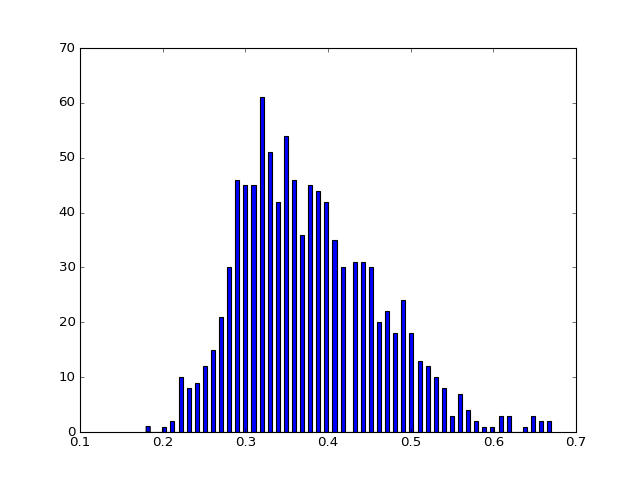

In [197]:
print np.mean(choose_bet)
print np.std(choose_bet)

print 'I can play this game with bet in [{}, {}] with 95% confidence'.format(np.mean(choose_bet)-2*np.std(choose_bet), np.mean(choose_bet)+2*np.std(choose_bet))
plt.figure('bet')
plt.hist(choose_bet, bins=100)
plt.show()